# Exercise Sheet No. 11

---

> Machine Learning for Natural Sciences, Summer 2021, Jun.-Prof. Pascal Friederich, pascal.friederich@kit.edu
> 
> Deadline: 05.07.2021, 8 am
> 
> Tutor: luca.torresi@kit.edu  
> **Please ask questions in the forum and only contact the Tutor when there are issues with the grading**

---
**Topic**: This exercise sheet will introduce you to generative models in machine learning.

# Variational AutoEncoders

In this exercise we will work on Variational AutoEncoders, first introduced by Welling and Kingma in a popular paper published in 2014 (https://arxiv.org/pdf/1312.6114.pdf).
We will implement a vanilla version of VAE, with encoder and decoder composed of fully connected layers only, and try to use it for an anomaly detection task. We will then see how we can impose nice properties on the latent representation of data produced by the network simply augmenting it with a linear regressor.

In [1]:
%matplotlib notebook
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sb
from collections import Counter

from typing import Optional
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

from Utils import get_data, AbstractTrainer, plot_reconstr

Let's take a look at our data we will work on.

The dataset consists of ECG segments of healthy patients and patients suffering from premature ventricular contraction (PVC). Segments were padded/cut to measure 350 time steps each.

In the first part of the exercise we will implement a detector for anomalous hearbeats, thus our training and validation sets will consist of normal heartbeats only while in the test set we will have both normal and PVC ECGs.

In [2]:
np.random.seed(101)
train, val, test = get_data(batch_size=1)
print(f'Dimension of \n\t train set : {len(train)} data points \n\t validation set : {len(val)} data points \n\t test set : {len(test)} data points')
counts = Counter()
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True)
for batch in test:
    if sum(counts.values())==6:
            break
    data = batch['data']
    label = batch['labels']
    if label==0 and counts[0]<3:
        axs[0, counts[0]].plot(np.arange(350), data.squeeze())
        counts[0] += 1
    if label==1 and counts[1]<3:
        axs[1, counts[1]].plot(np.arange(350), data.squeeze())
        counts[1] += 1
axs[0,0].set_ylabel('Normal')
axs[1,0].set_ylabel('PVC')
fig.tight_layout()
fig.show()

Dimension of 
	 train set : 6585 data points 
	 validation set : 997 data points 
	 test set : 1275 data points


<IPython.core.display.Javascript object>

An autoencoder is an unsupervised representation learning algorithm based on neural networks that is used to learn efficient codings of unlabeled data. In particular, by imposing a bottleneck in the encoding layer of the network we can extract a compressed representation of the original input leveraging the structure present in it, i.e. the correlations among input features. 

In an AE input data is converted into a deterministic encoding vector, i.e. for each of the latent features the encoder outputs a single value. VAEs are an extension of AE int the sense that instead of performing a single value estimation of the latent vector they produce a probabilistic distribution $q_{\phi}(z|x)$ in the latent space. This is done through a variational bayesian inference: an approximation of the distribution is picked from some tractable family and then this is made as close as possible to the true posterior. In particular in the original formulation of VAE the prior imposed on the latent representation is a standard Gaussian and the mean field approximation is used, i.e. the latent variables are considered as independent from each other.

Being the latent representation of our data a probabilistic distribution, to reconstruct input data we have to sample points from it $z$~$q_{\phi}(z|x)$. The fact that one of the nodes in the computational graph is a random node would create a problem in the backpropagation step because the gradient would not be able to 'flow' through it.

One of the key elements in the VAE architecture is the so called 'reparameterization trick', that allow us to express a distribution $q_{\phi}(z|x)$ as a two-step generative process:
1. sample a noise variable $\epsilon$ from a simple distribution:
2. apply a deterministic transformation $g_{\phi}(\epsilon,x)$ that maps the random noise into a more complex distribution.


In the case of Gaussian distributions the reparametrization trick is particularly simple: instead of writing $z$∼$q_{\phi}(z|x)=\mathcal{N}(\mu_{\phi}, \Sigma_{\phi})$ we can just write $z=g_{\phi}(\epsilon, x)= \mu_{\phi} +  \sigma_{\phi}*\epsilon$,  where $\epsilon$∼$\mathcal{N}(0,1)$.

In the following a partial implementation of a simple VAE with MLPs as encoder and decoder is provided. Complete the functions, paying attention to the fact that the encoder has to produce the logarithm of the standard deviation of each of the latent variables (this is done to ensure that the standard deviation is always positive).

Hint: torch has a function similar to numpy.random.randn

In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim : int = 350, embedding_dim : int = 30):
        super().__init__()
        self.embedding_dim = embedding_dim

        self.fc_input = nn.Sequential(nn.Linear(input_dim, 500),
                    nn.LeakyReLU(negative_slope=0.2),
                    nn.Dropout(0.4)
                    )
        self.fc_mean = nn.Linear(500, embedding_dim)
        self.fc_logstd = nn.Sequential(nn.Linear(500, embedding_dim),
                                    nn.LeakyReLU(negative_slope=0.05)
                                   )
        
        self.decoder = nn.Sequential(nn.Linear(embedding_dim, 500),
                    nn.LeakyReLU(negative_slope=0.2),
                    nn.Dropout(0.4),
                    nn.Linear(500, input_dim)
                    )

    def encode(self, x):
        '''
        The encoder is composed of a first fully connected layer followed by 
        two parallel linear layers that generate independently the mean and logstd of the latent distribution
        '''
        temp = None
        mean, logstd = None, None
        # YOUR CODE HERE
        temp = self.fc_input(x)
        mean = self.fc_mean(temp)
        logstd = self.fc_logstd(temp)
        return mean, logstd
        
    def reparameterize(self, mean, logstd): 
        '''
        Once the latent distribution is computed from the input a latent vector has to be sampled from it.
        We are working on gaussians, look at the formula in the block above 
        and remember that the encoder produces the logstd.
        
        std = None
        eps = None
        z = None
        # YOUR CODE HERE
        std = torch.exp(logstd)
        eps = torch.normal(0.0, 1.0, size=mean.shape) # torch.randn(self.embedding_dim)
        z = mean + std * eps
        return z
        '''
        '''
        Once the latent distribution is computed from the input a latent vector has to be sampled from it.
        We are working on gaussians, look at the formula in the block above 
        and remember that the encoder produces the logstd.
        '''
        std = None
        eps = None
        z = None
        
        std = torch.exp(logstd)
        eps = torch.normal(mean=0.0, std=1.0, size = mean.shape)
        
        z = mean + std * eps
        
        return z

    def forward(self, x):
        '''
        VAE computes the latent distribution associated with the input, 
        samples a vector from it and finally decodes it.
        '''
        mean, logstd = None, None
        z = None
        out = None 
        # YOUR CODE HERE
        mean, logstd = self.encode(x)
        z = self.reparameterize(mean, logstd)
        out = self.decoder(z)
        return [out, mean, logstd, z]
    

In [4]:
# encode - 1 point

vae = VAE(1,2)
m, s = vae.encode(torch.Tensor([1]))
assert m.shape==s.shape and m.shape==torch.Size([2]), 'error in encodings dimension'

# other hidden tests

In [5]:
# reparametrize - 1 point

vae = VAE(1,2)
s = vae.reparameterize(torch.Tensor([0,0]), torch.log(torch.tensor([1,1])))
assert s.size()==torch.Size([2]), 'error in dimension of generated random vector'

# other hidden tests

In [6]:
# forward - 1 point

# hidden tests... 

What we want to maximize in variational Bayes methods is the ELBO, which stands for "evidence lower bound":

$
\begin{align}
ELBO(\theta, \phi) = [\mathbb{E}_{q_{\phi}(z)}[\log p_{\theta}(x, z) - \log q_{\phi}(z|x)] ] = \\
-KL[q_{\phi}(z|x)|| p_{\theta}(z)] + \frac{1}{L} \sum_{l=1}^{L} \log p_{\theta}(x|z^{(l)})
\end{align}
$

where $q_{\phi}(z|x)$ represents the encoder and $\log p_{\theta}(x|z^{(l)})$ is the loglikelihood of the reconstruction and depends on the decoder parameters.

The KL (Kullback–Leibler) divergence is a measure of how similar two probability distributions are (if equal -> KL=0) and it is also known as relative entropy. Note that the KL divergence is not a distance metric since it is not symmetric.

The KL divergence of some families of distributions can be computed analytically and that's the case if we choose Gaussians priors and posteriors.

Implement the KL divergence between a Gaussian posterior $q_{\phi}(z|x) = \mathcal{N}(\mu, \Sigma)$, where $\Sigma = diag(\sigma_{j})$ with $j \in {1, ..., J}$, and a standard Gaussian prior $p(z) = \mathcal{N}(0, I)$ : &emsp; $-\frac{1}{2} \sum_{j=1}^{J} (1 + \log((\sigma_{j})^{2}) - (\mu_{j})^{2} - (\sigma_{j})^2)$

<br><br><br>

<img src="vae.png" style="width: 500px;">





In [51]:
def KL_normnorm(mean, logstd):
    '''
    implement the closed form of KL divergence for a gaussian as posterior and a standard gaussian as prior
    '''
    kl = None
    # YOUR CODE HERE
    
    kl = -(1/2) * torch.sum(1+2*logstd-torch.square(mean)-torch.square(torch.exp(logstd)))
    return kl

In [52]:
# kl_divergence - 1 point

mean = torch.randn(3)
logstd = abs(torch.randn_like(mean))
try:
    KL_normnorm(mean, logstd).item()
except:
    print('KL divergence of two probability distributions is a number, not a vector...')

# other hidden tests

Differently from the original formulation of VAE we are going to multiply the KL divergence with a scalar parameter in such a way to regulate the tradeoff between the two terms of the ELBO loss (this is somehow similar to beta-VAE: https://openreview.net/references/pdf?id=Sy2fzU9gl). Then, as suggested in https://arxiv.org/pdf/1511.06349.pdf, we will initially set this parameter to zero and increase it linearly w.r.t. the number of epochs (this approach is termed KL warmup).

In [53]:
class VAE_Trainer(AbstractTrainer):
    def __init__(self, model : nn.Module, 
                 train_loader : Optional[DataLoader] = None, 
                 val_loader : Optional[DataLoader] = None,
                 test_loader : Optional[DataLoader] = None, 
                 optimizer = None):
        super().__init__(model=model,
                         train_loader = train_loader, 
                         val_loader = val_loader, 
                         test_loader = test_loader, 
                         optimizer = optimizer,
                         kl_scaling = 0.1)
        self.measures = {'loss' : [], 'reconstr' : []}

    def _loss(self, target, label, *args):
        out = args[0] 
        mean = args[1]
        logstd = args[2]
        batch_dim = target.shape[0]
        reconstr_error = self.reconstr_loss(out, target).sum()/batch_dim
        kl = KL_normnorm(mean, logstd)/batch_dim
        loss = reconstr_error + kl * self.kl_scaling * (self.ep/self.epochs) # kl * scaling * warmup_term
        return [loss, reconstr_error]

    def test(self):
        self.model.eval()
        reconstr_errors = []
        with torch.no_grad():
            for batch in self.train_loader:
                data = batch['data'].to(self.device)
                out, mean, logstd, z = self.model(data)
                reconstr_error = self.reconstr_loss(out, data).sum(-1)
                reconstr_errors.append(reconstr_error)
        reconstr_errors = torch.cat(reconstr_errors)
        thresh = torch.quantile(reconstr_errors, 0.85)
        print(f'reconstr_errors avg : {reconstr_errors.mean()}, thresh : {thresh}')
        fig, ax = plt.subplots()
        ax.hist(reconstr_errors.numpy(), bins=np.arange(0, 15, 0.125))
        ax.set_title('train')
        ax.axvline(x=thresh, c='red')
        fig.show()

        reconstr_errors = []
        labels = []
        with torch.no_grad():
            for batch in self.test_loader:
                data = batch['data'].to(self.device)
                label = batch['labels'].to(self.device).squeeze()
                out, mean, logstd, z = self.model(data)
                reconstr_error = self.reconstr_loss(out, data).sum(-1)
                reconstr_errors.append(reconstr_error)
                labels.append(label)
        reconstr_errors = torch.cat(reconstr_errors)
        labels = torch.cat(labels)

        outliers_error = reconstr_errors[labels==1]
        normal_error = reconstr_errors[labels==0]
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
        ax1.hist(normal_error.numpy(), bins=np.arange(0, 15, 0.125))
        ax1.set_title('normal')
        ax1.axvline(x=thresh, c='red')
        ax2.hist(outliers_error.numpy(), bins=np.arange(0, 15, 0.125))
        ax2.set_title('anomalies')
        ax2.axvline(x=thresh, c='red')
        fig.show()
        print(f' avg recontruction error \n \t normal data : {normal_error.mean()}, anomalies : {outliers_error.mean()}')
        
        fig, ax = plt.subplots()
        preds = (reconstr_errors>thresh).float()
        cm = confusion_matrix(labels.numpy(), preds.numpy(), normalize='true')
        sb.heatmap(cm, square=True, xticklabels=False, yticklabels=False, 
                    annot=True, cbar=False, cmap="Reds", fmt='.2f').get_figure()
        ax.set_title('Anomaly detection: confusion matrix')
        fig.show()
        
        ##compute precision, recall and f1-score
        # precision = true_positive/(true_positive + false_positive)
        # recall = true_positive/(true_positive + false_negative)
        true = labels==1            
        tp = preds[true].sum()      # true_positive
        pos = (preds==1).sum()      # (true_positive + false_positive)
        true = true.sum()           # (true_positive + false_negative)
        
        precision = tp/pos
        recall = tp/true
        F1_score = 2*(precision * recall)/(precision + recall)
        
        print(f'Quality measures of our classifier:\n\t precision : {precision}\n\t recall : {recall}\n\t F1_score : {F1_score}')


We will now train our network on the 'normal' ECGs for a cycle of 100 epochs, without using any early stopping criteria, with a scaling constant of 0.1 for the KL divergence and using KL warmup. We will then use our VAE as anomaly detector on a test set composed of an equal (more or less) number of 'normal' and 'PVC' ECGs. 

To do so we will compute the distribution of the reconstruction errors over the training set, we will get the 0.85 (arbitrarily) quantile of the distribution and use it as a threshold to classify unseen data as belonging or not to the 'normal' class. 

Graphs produced are:
1. summary of training
2. few examples of reconstruction of test data
3. distribution of reconstruction errors on training set and 0.85 quantile in red
4. distribution of reconstruction errors on test set, separately for the 2 classes (threshold in red)
5. confusion matrix associated to our detector

Three measures were computed to evaluate our classifier: precision, recall and F1 score. Check the code above to see how these are computed.

In [54]:
np.random.seed(66)
torch.manual_seed(66)

train_loader, val_loader, test_loader = get_data()
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

trainer = VAE_Trainer(model = model,
                      train_loader = train_loader, 
                      val_loader = val_loader, 
                      test_loader = test_loader, 
                      optimizer = optimizer)

model = trainer.train(plot=True)
plot_reconstr(model, test_loader)
trainer.test()


===> epoch: 0
Train	loss : 73.986559 reconstr : 73.986559 
Val	loss : 43.395504 reconstr : 43.395504 

===> epoch: 1
Train	loss : 50.511504 reconstr : 50.509089 
Val	loss : 27.145975 reconstr : 27.141354 

===> epoch: 2
Train	loss : 35.588879 reconstr : 35.568767 
Val	loss : 16.622705 reconstr : 16.59487 

===> epoch: 3
Train	loss : 23.22956 reconstr : 23.174387 
Val	loss : 12.947926 reconstr : 12.897712 

===> epoch: 4
Train	loss : 18.762647 reconstr : 18.684636 
Val	loss : 10.077211 reconstr : 9.997943 

===> epoch: 5
Train	loss : 15.858024 reconstr : 15.75359 
Val	loss : 10.130978 reconstr : 10.038104 

===> epoch: 6
Train	loss : 13.864088 reconstr : 13.741784 
Val	loss : 8.761674 reconstr : 8.640042 

===> epoch: 7
Train	loss : 12.62622 reconstr : 12.464529 
Val	loss : 8.445037 reconstr : 8.291406 

===> epoch: 8
Train	loss : 11.000452 reconstr : 10.805599 
Val	loss : 7.634377 reconstr : 7.443258 

===> epoch: 9
Train	loss : 9.907378 reconstr : 9.672204 
Val	loss : 7.029135 recons

<IPython.core.display.Javascript object>

Let's plot some reconstructed data: 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

reconstr_errors avg : 3.9018948078155518, thresh : 5.238183975219727


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 avg recontruction error 
 	 normal data : 3.795135974884033, anomalies : 9.160813331604004


<IPython.core.display.Javascript object>

Quality measures of our classifier:
	 precision : 0.875806450843811
	 recall : 0.8687999844551086
	 F1_score : 0.8722891211509705


A vantage of having a probabilistic representation of the encodings is that we can extract uncertainties over the reconstructed data. In the following cell we will perform a simple Monte Carlo evaluation of the uncertainties and plot confidence intervals around the mean reconstruction of the input.

<ipython-input-58-d67bf74e9ba8>:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


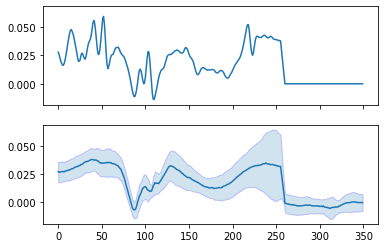

In [58]:
torch.manual_seed(11)
data = next(iter(train_loader))['data'][0]
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
ax[0].plot(np.arange(350), data)

model.eval()
mean, logstd = model.encode(data)
reconstructed_l = []
for i in range(10):
    z = model.reparameterize(mean, logstd)
    reconstructed_l.append(model.decoder(z).unsqueeze(0))
reconstructed = torch.cat(reconstructed_l, axis=0)
mean = reconstructed.mean(axis=0).detach().numpy()
std = reconstructed.std(axis=0).detach().numpy()
ax[1].plot(np.arange(350), mean)
ax[1].fill_between(np.arange(350), mean + 2*std, mean - 2*std, alpha=0.2, edgecolor='blue')
fig.show()

VAEs can be used to generate new datapoints. Once the network has been trained, we can sample latent representations from the prior distribution (in our case a standard gaussian) and decode them to produce new unseen data. The same mechanism is at the base of GANs. 

Try to produce new data yourself (the box is not graded).

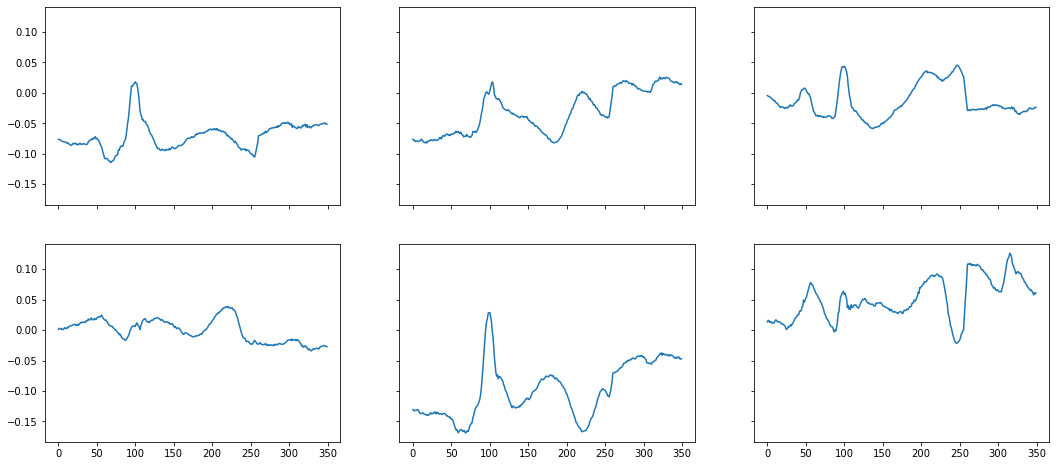

In [72]:
torch.manual_seed(12)
size = model.embedding_dim
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(18,8))
for i in range(6):
    sample = None           # sample from the prior (standard normal)
    new_data = None         # feed the sample to the decoder to produce new data
    
    sample = torch.randn(size)
    new_data = model.decoder(sample).unsqueeze(0).mean(axis=0).detach().numpy()
    
    # if you get an error in the plot function, just have a look at how plots were produced in the block above
    axs[i%2,i%3].plot(np.arange(350), new_data)
# fig.show()

We have seen the basic structure of a VAE, tested it on a anomaly detection task and seen how new data can be generated by means of the decoder. We will now see how we can enforce simple properties on the representations in the latent space.

By minimizing the KL we are forcing the representations (remember that these are distributions, not single values) produced by the encoder to be as close as possible to a standard normal. We could go beyond this and impose, for example, that the distributions of representations corresponding to different classes of data occupy different volumes of the latent space.

Our training set will now consist of ECGs of both 'normal' and 'PVC' classes, we will train, in parallel to the VAE, a linear classifier on the means of the distributions produced by the encoder. In this way the means of the distributions corresponding to different classes will be pushed in linearly separable volumes of the latent space.

Implement a simple classifier of one single fully connected layer. Select the right activation function for a binary classifier (you have already encountered it in a previous exercise).

Hint: torch.nn module has useful functions...

In [73]:
class Composed(nn.Module):
    def __init__(self, input_dim : int = 350, embedding_dim : int = 3):
        super().__init__()
        self.vae = VAE(input_dim, embedding_dim)
        self.classifier = BinaryClassifier(embedding_dim)
    def forward(self, data):
        out, mean, logstd, z = self.vae(data)
        logits = self.classifier(mean).squeeze()
        return [out, mean, logstd, z, logits]


class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Linear(in_features=input_dim, out_features=1)  # f(ully)c(onnected)
        self.activation = nn.Sigmoid()   # we need a differentiable function between 0 and 1... 
        
        
    def forward(self, data):
        return self.activation(self.fc(data))

In [74]:
# Binary_classifier - 1 point

# hidden tests (checking nn.layers)

Try to implement the loss of our new architecture. It will have to be composed by 3 additive terms: the likelihood for the reconstruction, the kl divergence for the prior and a term for the binary classifier. 

(For this task you may drop the KL warmup)

Hints: 
1. maybe you want to take a look at the VAE_Trainer loss function implemented above...
2. ComposedTrainer class has a new attribute. What is the BCELoss? 
3. remember that you already implemented a function for the KL divergence 
4. have you asked yourself what is the meaning of "reduction='none'" in the torch.nn functions we used?

In [90]:
class ComposedTrainer(AbstractTrainer):
    def __init__(self, model : nn.Module, 
                 train_loader : Optional[DataLoader] = None, 
                 val_loader : Optional[DataLoader] = None,
                 test_loader : Optional[DataLoader] = None, 
                 optimizer = None):
        super().__init__(model=model,
                         train_loader = train_loader,
                         val_loader = val_loader,
                         test_loader = test_loader,
                         optimizer = optimizer,
                         early_stop = 2)
        self.class_loss = nn.BCELoss(reduction='none')       
        self.measures = {'loss' : [], 'reconstr' : [], 'classif' : []}

    def _loss(self, target, label, *args):
        out = args[0] 
        mean = args[1]
        logstd = args[2]
        logits = args[4]
        batch_dim = target.shape[0]
        #                               <============================ THE FOLLOWING 4 LINES ONLY
        reconstr_error = self.reconstr_loss(out, target).sum()/batch_dim  # an old friend
        kl = KL_normnorm(mean, logstd)/batch_dim  # another old friend
        classif_error = self.class_loss(logits, label).sum()/batch_dim  # a new one
        loss = reconstr_error + self.kl_scaling * kl + classif_error               
        
        return [loss, reconstr_error, classif_error]

    def test(self):
        self.model.eval()
        means = []
        labels = []
        preds = []
        with torch.no_grad():
            for batch in self.val_loader:
                data = batch['data'].to(self.device)
                label = batch['labels'].to(self.device).squeeze()
                out, mean, logstd, z, logits = self.model(data)
                means.append(mean)
                labels.append(label)
                preds.append((logits>0.5).float())
        labels = torch.cat(labels).numpy().astype('int')
        preds = torch.cat(preds).numpy().astype('int')
        
        fig, ax = plt.subplots()
        cm = confusion_matrix(labels, preds, normalize='true')
        sb.heatmap(cm, square=True, xticklabels=False, yticklabels=False, 
                    annot=True, cbar=False, cmap="Reds", fmt='.2f').get_figure()
        ax.set_title('Classification: confusion matrix')
        # fig.show()


        means = torch.cat(means).numpy()
        colors={0: 'blue', 1:'red'}
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.scatter(means[:,0], means[:,1], means[:,2], marker=".", s=20, c=[colors[i] for i in labels])
        ax.set_title('Latent space')
        # fig.show()


In [91]:
# Composed_Loss - 1 point

# hidden tests... did you check the hints?

We will now train our network for a cycle of 100 epochs, using as early stopping criteria the classification error on the validation set, with a scaling constant of 0.5 for the KL divergence and using (or not) KL warmup. 

Graphs produced are:
1. summary of training
2. confusion matrix associated to the binary classifier
4. interactive 3D graph in the latent space of the means of the representation distributions produced by the encoder on the validation set


===> epoch: 0
Train	loss : 61.876994 reconstr : 61.131463 classif : 0.736131 
Val	loss : 25.918457 reconstr : 25.178828 classif : 0.730288 
Model saved

===> epoch: 1
Train	loss : 40.57633 reconstr : 39.811491 classif : 0.71752 
Val	loss : 19.957233 reconstr : 19.107569 classif : 0.716224 
Model saved

===> epoch: 2
Train	loss : 26.750548 reconstr : 25.843705 classif : 0.702776 
Val	loss : 20.509265 reconstr : 19.4897 classif : 0.707687 
Model saved

===> epoch: 3
Train	loss : 20.995766 reconstr : 19.815776 classif : 0.696503 
Val	loss : 18.640839 reconstr : 17.318804 classif : 0.692033 
Model saved

===> epoch: 4
Train	loss : 16.76996 reconstr : 15.40239 classif : 0.68087 
Val	loss : 15.243195 reconstr : 13.836352 classif : 0.66537 
Model saved

===> epoch: 5
Train	loss : 16.445206 reconstr : 14.855014 classif : 0.661976 
Val	loss : 13.572723 reconstr : 11.878842 classif : 0.678845 

===> epoch: 6
Train	loss : 14.77648 reconstr : 12.971811 classif : 0.666783 
Val	loss : 12.397513 rec

/Users/ytatar/Yasin/01-Projects/21-04-16-KIT-SS2021-Aimat/kit-ml-natsc/Exericse_11/Utils.py:153: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


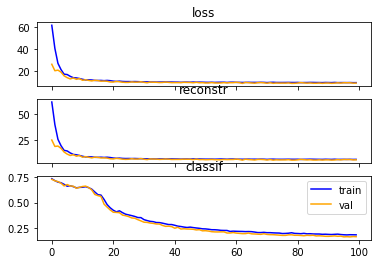

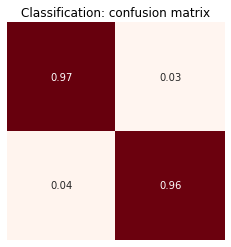

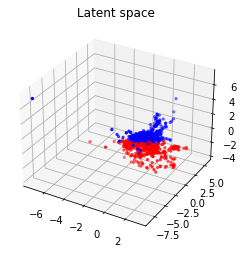

In [92]:
np.random.seed(666)
torch.manual_seed(666)

train_loader, val_loader, test_loader = get_data(composed=True)
model = Composed()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

trainer = ComposedTrainer(model = model,
                          train_loader = train_loader, 
                          val_loader = val_loader, 
                          test_loader = test_loader, 
                          optimizer = optimizer)

model = trainer.train(plot=True)
#     plot_reconstr(model, test_loader)
trainer.test()